Neural style transfer (NST) is a very neat idea. NST builds on the key idea that,it is possible to separate the style representation and content representations in a CNN, learnt during a computer vision task (e.g. image recognition task). Following this concept, NST employs a pretrained convolution neural network (CNN) to transfer styles from a given image to another. This is done by defining a loss function that tries to minimise the differences between a content image, a style image and a generated image.

In [0]:
# Uploading the images
from google.colab import files
uploaded = files.upload()

Saving Lionel-Messi.jpg to Lionel-Messi.jpg


In [0]:
from google.colab import files
uploaded = files.upload()

Saving Leonardo_da_Vinci.jpg to Leonardo_da_Vinci.jpg


In [0]:
# Importing the lib
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
import torchvision.models as models
import copy

**This is a function for image loading**

In [0]:
#image loading
imsize = 512,512

loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name):
	  image = Image.open(image_name)
	  image = loader(image).unsqueeze(0)
	  return image.to(torch.float)

style_img = image_loader('Leonardo_da_Vinci.jpg')
content_img = image_loader('Lionel-Messi.jpg')

assert style_img.size() == content_img.size()


**This is a function for displaying the images**

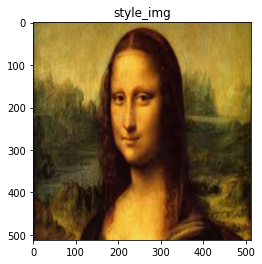

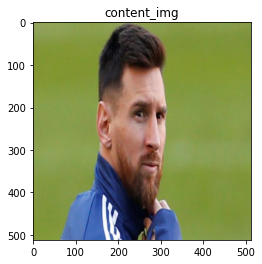

In [0]:
unloader = transforms.ToPILImage()

plt.ion()

# dis playing the images
def imshow(tensor, title=None):
    image = tensor.clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
	
plt.figure()
imshow(style_img, title='style_img')

plt.figure()
imshow(content_img, title='content_img')


**Loss functions**
In this section we define two loss functions; the content loss function and the style loss function. The content loss function ensures that the activations of the higher layers are similar between the content image and the generated image. The style loss function makes sure that the correlation of activations in all the layers are similar between the style image and the generated image. 


**Content loss function**
The content cost function is making sure that the content present in the content image is captured in the generated image. It has been found that CNNs capture information about content in the higher levels, where the lower levels are more focused on individual pixel values . Therefore we use the top-most CNN layer to define the content loss function.
Let A^l_{ij}(I) be the activation of the l th layer, i th feature map and j th position obtained using the image I. Then the content loss is defined as,Essentially L_{content} captures the root mean squared error between the activations produced by the generated image and the content image.


In [0]:
#content loss
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

**Gram Matrix**
The main idea behind the paper is using Gram Matrix for style transfer. It was shown in these 2 papers that Gram Matrix in feature map of convolutional neural network(CNN) can represent the style of an image and propose the neural style transfer algorithm for image stylization.
Texture Synthesis Using Convolution Neural Networks by Gatys et al. 2015
Image Style Transfer Using Convolutional Neural Networks by Gatys et al. 2016
Details about gram matrix can be found on wikipedia. Mathematically, given a vector V gram matrix is computed as
g = v^t * v

In [0]:
#gram matrix
def gram_matrix(input):
    a, b, c, d = input.size()

    features = input.view(a * b, c * d)

    G = torch.mm(features, features.t())

    return G.div(a * b * c * d)

**Style loss function**
Defining the style loss function requires more work. To extract the style information from the VGG network, we use all the layers of the CNN. Furthermore, style information is measured as the amount of correlation present between features maps in a given layer. Next, a loss is defined as the difference of correlation present between the feature maps computed by the generated image and the style image. Mathematically, the style loss is defined as,w^l (chosen uniform in this tutorial) is a weight given to each layer during loss computation and M^l is an hyperparameter that depends on the size of the l th layer. If you would like to see the exact value, please refer to this paper. However in this implementation, you are not using M^l as that will be absorbed by another parameter when defining the final loss.

In [0]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

**Downloading and loading the pretrained VGG-19**
You will be borrowing the VGG-19 weights using transfer learning

In [0]:
# importing the model
cnn = models.vgg19(pretrained=True).features.eval()

normalization_mean = torch.tensor([0.485, 0.456, 0.406])
normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):

    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
#choosing layers
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, 
	                          normalization_std, 
	                          style_img, content_img,
	                          content_layers=content_layers_default,
	                          style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer:{}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)

    print(len(model))

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    print(len(model))

    return model, style_losses, content_losses

    

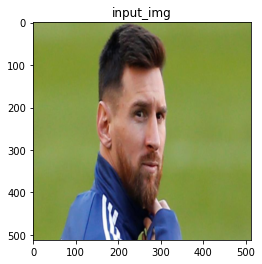

In [0]:
#select input image
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='input_img')

**Defining the optimizer**

In [0]:
#gradient descent
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

**Defining the input pipeline for runing the style transfer**

In [0]:
#run style transfer
def run_style_transfer(cnn, normalization_mean, normalization_std,
	                   content_img, style_img, input_img, num_steps=600,
	                   style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
    	  normalization_mean, normalization_std, style_img, content_img)
    
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for s1 in style_losses:
                style_score += s1.loss
            for c1 in content_losses:
                content_score += c1.loss
            
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print('run {}'.format(run))
                print('Style Loss: {:4f} Content Loss: {:4f}'.format(
                	  style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

**Runing the algorithm**

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


44
18
Optimizing..
run [50]
Style Loss: 53.424671 Content Loss: 5.931994

run [100]
Style Loss: 28.043966 Content Loss: 5.613910

run [150]
Style Loss: 18.614340 Content Loss: 5.801186

run [200]
Style Loss: 12.923557 Content Loss: 7.273410

run [250]
Style Loss: 8.824121 Content Loss: 6.317127

run [300]
Style Loss: 6.802576 Content Loss: 5.264358

run [350]
Style Loss: 6.540175 Content Loss: 4.948877

run [400]
Style Loss: 4.793795 Content Loss: 4.867245

run [450]
Style Loss: 4.371453 Content Loss: 5.057299

run [500]
Style Loss: 3.305578 Content Loss: 5.859588

run [550]
Style Loss: 2.530192 Content Loss: 4.725329

run [600]
Style Loss: 2.323602 Content Loss: 4.435545



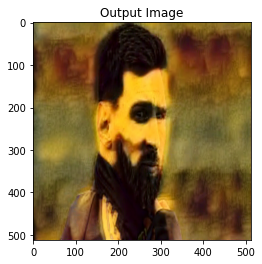

In [0]:
#run the algorithm
output = run_style_transfer(cnn, normalization_mean, normalization_std,
	                        content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()